# Assignment 3: Image Retrieval from Latent Representation of Autoencoder

* Credits: 30
* Submit .ipynb, .html to maucher(at)hdm-stuttgart.de

## Idea
In notebook [01ImageRetrieval.ipynb](../imageRetrieval/01ImageRetrieval.ipynb) it has been shown how pretrained deep neural networks can be applied to calculate meaningful features. These meaningful features can be applied e.g. for image retrieval, i.e. similarities between images are not determined on the basis of pixels but on the basis of the feature-vectors calculated by deep neural networks. 

In this assignment another neural-network based approach to calculate meaningful feature-vectors of images shall be implemented: First an Autoencoder is trained. Then, from the trained network the latent-representation-layer (see below) is accessed. The layer contains the meaningful-features of the image, which is currently at the input of the network. In this way we calculate meaningful-feature vectors for all images and determine image similarities on the basis of these vectors.   

## Autoencoder

An autoencoder consists of an encoder- and a decoder-module. The encoder maps each input $\mathbf{x}$ to a latent representation $\mathbf{y}$, such that the decoder network is able to calculate a reconstruction $\mathbf{z}$ from $\mathbf{y}$, whereby $\mathbf{z}$ must be as close as possible to the input $\mathbf{x}$. The weights of the encoder- and decoder- module are learned by minimizing a loss-function, which measures the difference between the reconstruction $\mathbf{z}$ and the original $\mathbf{x}$. For this standard gradient descent supervised learning algorithms, such as backpropagation can be applied. Even though the inputs must not be labeled (the target ist the input itself)! 
<img src="https://maucher.home.hdm-stuttgart.de/Pics/autoencoder.png" alt="Drawing" style="width: 800px;"/>
Usually the latent representation $\mathbf{y}$ is much smaller, than the original $\mathbf{x}$ and it's reconstruction $\mathbf{z}$. Hence, the entire process realizes a standard lossy compression, such as e.g. jpeg-encoding of images.

The latent-representation contains the relevant information of the image - otherwise it would not be able to reconstruct the original from this small representation. This means, that the latent representation of the image, which is currently at the input of the Autoencoder is a gut feature-representation of the image and can be applied e.g. for image retrieval.

## Define, train and evaluate Autoencoder 

### Task 1
In this task the architecture and the training of the autoencoder are already given. Just execute these codecells and try to understand the implementation:

In [1]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

Define the path, where the trained model shall be saved:

In [2]:
modelpath="output/autoencoderCifar128.h5"

Load Cifar10 dataset:

In [3]:
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = cifar10.load_data()

[INFO] loading MNIST dataset...


Normalize training- and test-images

In [4]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

Define height, width and number of channels of the images:

In [5]:
width=height=32
depth=3

Define number of features in the Conv-Layers and the dimension of the latent representation:

In [6]:
filters=(32, 64)
latentDim=128

Create Autoencoder:

In [7]:
inputShape = (height, width, depth)
chanDim = -1

# define the input to the encoder
inputs = Input(shape=inputShape)
x = inputs

# loop over the number of filters
for f in filters:
    # apply a CONV => RELU => BN operation
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chanDim)(x)

# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latentDim, name="encoded")(x)

# start building the decoder model which will accept the
# output of the encoder as its inputs
x = Dense(np.prod(volumeSize[1:]))(latent)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

# loop over our number of filters again, but this time in
# reverse order
for f in filters[::-1]:
        # apply a CONV_TRANSPOSE => RELU => BN operation
        x = Conv2DTranspose(f, (3, 3), strides=2,
            padding="same")(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = BatchNormalization(axis=chanDim)(x)

# apply a single CONV_TRANSPOSE layer used to recover the
# original depth of the image
x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
outputs = Activation("sigmoid", name="decoded")(x)

# construct our autoencoder model
autoencoder = Model(inputs, outputs, name="autoencoder")

In [8]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          

In the archictecture, defined above, the latent representation is at the layer, which is named `encoded`.

Define Training parameters: number of epochs to train for, initial learning rate and batch size

In [9]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

Define the optimizer to be used for training:

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

Train Autoencoder:

In [12]:
H = autoencoder.fit(
    trainX, trainX,
    validation_data=(testX, testX),
    epochs=EPOCHS,
    batch_size=BS)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 192s 4ms/sample - loss: 0.0094 - val_loss: 0.0055
Epoch 2/20
50000/50000 [==============================] - 196s 4ms/sample - loss: 0.0059 - val_loss: 0.0054
Epoch 3/20
50000/50000 [==============================] - 166s 3ms/sample - loss: 0.0056 - val_loss: 0.0051
Epoch 4/20
50000/50000 [==============================] - 161s 3ms/sample - loss: 0.0055 - val_loss: 0.0049
Epoch 5/20
50000/50000 [==============================] - 159s 3ms/sample - loss: 0.0053 - val_loss: 0.0050
Epoch 6/20
50000/50000 [==============================] - 142s 3ms/sample - loss: 0.0052 - val_loss: 0.0048
Epoch 7/20
50000/50000 [==============================] - 154s 3ms/sample - loss: 0.0051 - val_loss: 0.0049
Epoch 8/20
50000/50000 [==============================] - 164s 3ms/sample - loss: 0.0049 - val_loss: 0.0048
Epoch 9/20
50000/50000 [==============================] - 153s 3ms/sample - loss: 0.00

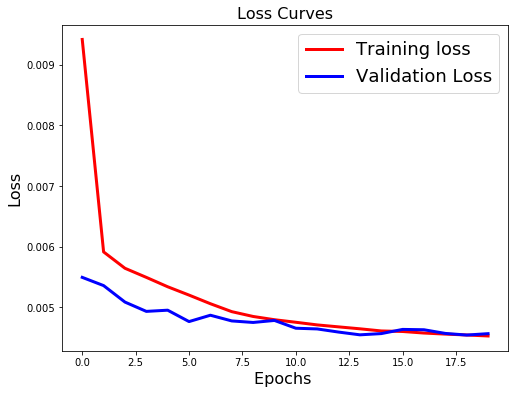

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(H.history['loss'],'r',linewidth=3.0)
plt.plot(H.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()

Persistently save the trained model:

In [15]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(modelpath, save_format="h5")

[INFO] saving autoencoder...


## Load the trained Autoencoder
In the following codecells only the encoder part of the trained Autoenocder is extracted:

In [ ]:
from tensorflow.keras.models import load_model

In [11]:
autoencoder=load_model(modelpath)

In [12]:
encoder = Model(inputs=autoencoder.input,outputs=autoencoder.get_layer("encoded").output)

## Calculate latent representation of all training- and test-images
### Task 2
Apply the encoder's predict()-methode in order to calculate the latent representation of
* all training images
* all test images

These latent representations are the *meaningful feature vectors* of the images, which shall be used in the following tasks. 

## Determine for all test images the 5 closest training images
### Task 3
For all test-images determine the 5 nearest training-images. For this task test- and training-images shall be represented by their latent representations and euclidean distance shall be applied. Determine the *Top-5 Error Rate*. This is the ratio of test-images, whose 5 nearest training-images do not contain an image of the same class as the the test-image. 

### Bonus Task:
Improve the Autoencoder architecture and/or the training-parameters in order to obtain a better *Top-5-Error Rate*.
